In [1]:
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import statsmodels.api as sm
import pandas as pd
import glob
import re
from tqdm import tqdm
import scipy.io as sio
import os
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
plt.rc('font', size=22, family='arial') 
plt.rc('axes', linewidth=1.5)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.rc('mathtext', default='regular')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

monkey_names = ["W", "V"]

root_dir = '/Users/f005d7d/Documents/Attn_MdPRL/what-where-task/'
# root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'
figure_data_dir = os.path.join(root_dir, 'what-where-task-analysis', 'figures')

bhv_path = os.path.join(root_dir, 'Behavior/')
processed_path = os.path.join(root_dir, 'processed/')
neural_path = os.path.join(root_dir, 'RasterVec_binSize_10ms/')

all_sess_regression_info = {
    'aligned_event': [],
    'monkey_name': [],
    'area_name': [],
    'sess_date': [],
    'betas': [],
    'exp_vars': [],
    'pvals': []
}

regressor_names = ['CR_what', 'CR_where', 'WSLS_what', 'WSLS_where']
tbl_col_names = ['block_type', 'CR_what', 'CR_where', 'WSLS_what', 'WSLS_where', 'sess_id']

formula = 'choice~block_type*('+'+'.join(regressor_names)+')'

In [3]:
all_sess_task_info = []

for monkey_idx, monkey_name in enumerate(monkey_names):
    files = glob.glob(f'{bhv_path}/SPKcounts_{monkey_name}*cue_MW_250X250ms.mat')
    for sess_idx in range(len(files)):
        filename = files[sess_idx]

        sess_date = re.search(re.compile(f'{bhv_path}SPKcounts_{monkey_name}(\\d*)cue_MW_250X250ms.mat'), filename).groups()[0]

        curr_sess_bhv = sio.loadmat(filename)
        task_info = curr_sess_bhv['Y']

        # only keep chosen image, chosen loc, reward, block type, block id
        task_info = task_info[:, [0, 1, 2, 9, 8]].astype(float)

        trial_mask = task_info[:, 4] <= 24
        task_info = task_info[trial_mask]

        num_trials = task_info.shape[0]

        print("--------------------------------------------------------------------")
        print("monkey: " + monkey_name + ", session: " + sess_date + ", #trials=" + str(num_trials))

        task_info[:, :3] = task_info[:, :3]*2-1
        task_info[:, 3] = task_info[:, 3]*2-3 
        
        # curr_sess_block_ids = monkey_idx*8*24+sess_idx*24+task_info[1:,4]-1

        # put together design matrix
        # 'choice', 'type', 'CR_what', 'CR_where', 'WSLS_what', 'WSLS_where', 'sess_id'
        X = np.stack([(task_info[1:,1]+1)/2,
                      task_info[1:,3], 
                      task_info[1:,0]*task_info[1:,1]*task_info[:-1,0],
                      task_info[:-1,1],
                      task_info[1:,0]*task_info[1:,1]*task_info[:-1,0]*task_info[:-1,2],
                      task_info[:-1,1]*task_info[:-1,2],
                      monkey_idx*4+sess_idx+np.zeros(num_trials-1)], axis=1)
        
        all_sess_task_info.append(X)

all_sess_task_info = np.concatenate(all_sess_task_info, axis=0)



--------------------------------------------------------------------
monkey: W, session: 20160113, #trials=1920
--------------------------------------------------------------------
monkey: W, session: 20160112, #trials=1914
--------------------------------------------------------------------
monkey: W, session: 20160121, #trials=1893
--------------------------------------------------------------------
monkey: W, session: 20160122, #trials=1920
--------------------------------------------------------------------
monkey: V, session: 20160929, #trials=1920
--------------------------------------------------------------------
monkey: V, session: 20160930, #trials=1920
--------------------------------------------------------------------
monkey: V, session: 20161005, #trials=1920
--------------------------------------------------------------------
monkey: V, session: 20161017, #trials=1920


In [4]:
tbl = pd.DataFrame(all_sess_task_info, columns=['choice']+tbl_col_names)
mdl = smf.glm(formula, tbl, family=sm.families.Binomial()).fit()
print(mdl.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                15319
Model:                            GLM   Df Residuals:                    15309
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7127.9
Date:                Tue, 12 Nov 2024   Deviance:                       14256.
Time:                        22:03:59   Pearson chi2:                 1.53e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3660
Covariance Type:            nonrobust  

In [13]:
contrasts = mdl.t_test(np.array([
    [0,0,1,0,0,0,1,0,0,0],
    [0,0,1,0,0,0,-1,0,0,0],
    [0,0,0,1,0,0,0,1,0,0],
    [0,0,0,1,0,0,0,-1,0,0],
    [0,0,0,0,1,0,0,0,1,0],
    [0,0,0,0,1,0,0,0,-1,0],
    [0,0,0,0,0,1,0,0,0,1],
    [0,0,0,0,0,1,0,0,0,-1],
]))
print(contrasts.summary())

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0307      0.045     23.104      0.000       0.943       1.118
c1             1.5953      0.041     38.470      0.000       1.514       1.677
c2             1.4095      0.045     31.597      0.000       1.322       1.497
c3             0.7303      0.041     17.615      0.000       0.649       0.812
c4             0.5865      0.045     13.148      0.000       0.499       0.674
c5             0.8260      0.041     19.923      0.000       0.745       0.907
c6             0.9222      0.045     20.670      0.000       0.835       1.010
c7             0.5753      0.041     13.877      0.000       0.494       0.657


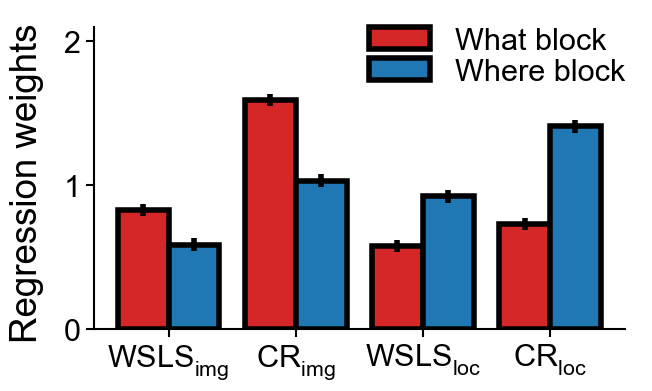

In [14]:
coeffs = np.array(contrasts.effect)
ses = np.array(contrasts.sd)


fig, ax = plt.subplots(1,1, figsize=(7.2, 4.2))


width=0.4

ax.bar(np.arange(4)-width/2, coeffs[[5,1,7,3]], yerr=ses[[5,1,7,3]], width=width, facecolor='tab:red', label='What block',
        edgecolor='k', linewidth=4, capsize=0, error_kw={'elinewidth': 4, 'capthick': 4})
ax.bar(np.arange(4)+width/2, coeffs[[4,0,6,2]], yerr=ses[[4,0,6,2]], width=width, facecolor='tab:blue', label='Where block',
        edgecolor='k', linewidth=4, capsize=0, error_kw={'elinewidth': 4, 'capthick': 4})

# ax.bar(np.arange(4), mdl.params.iloc[[4,2,5,3]], color=['deepskyblue', 'deepskyblue', 'limegreen', 'limegreen'])
# ax.errorbar(np.arange(4), mdl.params.iloc[[4,2,5,3]], mdl.bse.iloc[[4,2,5,3]], 
#                  ls='', color='k')

# ax.bar(np.arange(4), mdl.params.iloc[[4,2,5,3]], color=['tab:blue', 'tab:blue', 'tab:green', 'tab:green'])
# ax.errorbar(np.arange(4), mdl.params.iloc[[4,2,5,3]], mdl.bse.iloc[[4,2,5,3]], 
#                  ls='', color='k')

ax.set_xticks(np.arange(4))
ax.set_xticklabels([r'$WSLS_{img}$', r'$CR_{img}$', r'$WSLS_{loc}$', r'$CR_{loc}$'])


# axes[1].bar(np.arange(4), mdl.params.iloc[[8,6,9,7]]*np.array([-1,-1,1,1]), color=['deepskyblue', 'deepskyblue', 'limegreen', 'limegreen'])
# axes[1].errorbar(np.arange(4), mdl.params.iloc[[8,6,9,7]]*np.array([-1,-1,1,1]), mdl.bse.iloc[[8,6,9,7]], 
#                  ls='', color='k')
# axes[1].set_xticks(np.arange(4))
# axes[1].set_xticklabels([r'$\Delta WSLS_{img}$', r'$\Delta CR_{img}$', r'$\Delta WSLS_{loc}$', r'$\Delta CR_{loc}$'])

ax.set_ylim([0, 2.1])
fig.legend(frameon=False, labelspacing=0.1)
fig.supylabel('Regression weights', x=0.1, y=0.55)
sns.despine()
fig.tight_layout()


plt.savefig(os.path.join(figure_data_dir, "regression_weights.pdf"))


In [22]:
contrasts = mdl.t_test(np.array([
    [0,0,1,0,-1,0,1,0,-1,0],
    [0,0,1,0,1,0,1,0,1,0],
    [0,0,1,0,-1,0,-1,0,1,0],
    [0,0,1,0,1,0,-1,0,-1,0],
    [0,0,0,1,0,-1,0,1,0,-1],
    [0,0,0,1,0,1,0,1,0,1],
    [0,0,0,1,0,-1,0,-1,0,1],
    [0,0,0,1,0,1,0,-1,0,-1],
]))
print(contrasts.summary())

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.4441      0.037     11.938      0.000       0.371       0.517
c1             1.6172      0.081     19.943      0.000       1.458       1.776
c2             0.7693      0.040     19.401      0.000       0.692       0.847
c3             2.4213      0.073     33.243      0.000       2.279       2.564
c4             0.4873      0.037     13.096      0.000       0.414       0.560
c5             2.3317      0.081     28.753      0.000       2.173       2.491
c6             0.1550      0.040      3.909      0.000       0.077       0.233
c7             1.3057      0.073     17.928      0.000       1.163       1.448


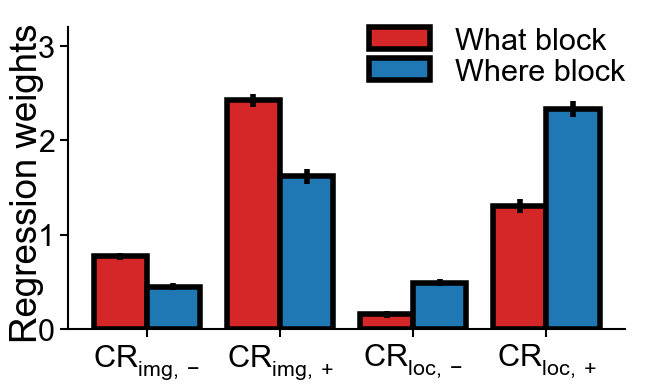

In [27]:
coeffs = np.array(contrasts.effect)
ses = np.array(contrasts.sd)


fig, ax = plt.subplots(1,1, figsize=(7.2, 4.2))


width=0.4

ax.bar(np.arange(4)-width/2, coeffs[[2,3,6,7]], yerr=ses[[2,3,6,7]], width=width, facecolor='tab:red', label='What block',
        edgecolor='k', linewidth=4, capsize=0, error_kw={'elinewidth': 4, 'capthick': 4})
ax.bar(np.arange(4)+width/2, coeffs[[0,1,4,5]], yerr=ses[[0,1,4,5]], width=width, facecolor='tab:blue', label='Where block',
        edgecolor='k', linewidth=4, capsize=0, error_kw={'elinewidth': 4, 'capthick': 4})

# ax.bar(np.arange(4), mdl.params.iloc[[4,2,5,3]], color=['deepskyblue', 'deepskyblue', 'limegreen', 'limegreen'])
# ax.errorbar(np.arange(4), mdl.params.iloc[[4,2,5,3]], mdl.bse.iloc[[4,2,5,3]], 
#                  ls='', color='k')

# ax.bar(np.arange(4), mdl.params.iloc[[4,2,5,3]], color=['tab:blue', 'tab:blue', 'tab:green', 'tab:green'])
# ax.errorbar(np.arange(4), mdl.params.iloc[[4,2,5,3]], mdl.bse.iloc[[4,2,5,3]], 
#                  ls='', color='k')

ax.set_xticks(np.arange(4))
ax.set_xticklabels([r'$CR_{img,-}$', r'$CR_{img,+}$', r'$CR_{loc,-}$', r'$CR_{loc,+}$'])


# axes[1].bar(np.arange(4), mdl.params.iloc[[8,6,9,7]]*np.array([-1,-1,1,1]), color=['deepskyblue', 'deepskyblue', 'limegreen', 'limegreen'])
# axes[1].errorbar(np.arange(4), mdl.params.iloc[[8,6,9,7]]*np.array([-1,-1,1,1]), mdl.bse.iloc[[8,6,9,7]], 
#                  ls='', color='k')
# axes[1].set_xticks(np.arange(4))
# axes[1].set_xticklabels([r'$\Delta WSLS_{img}$', r'$\Delta CR_{img}$', r'$\Delta WSLS_{loc}$', r'$\Delta CR_{loc}$'])

ax.set_ylim([0, 3.2])
fig.legend(frameon=False, labelspacing=0.1)
fig.supylabel('Regression weights', x=0.1, y=0.55)
sns.despine()
fig.tight_layout()


plt.savefig(os.path.join(figure_data_dir, "regression_weights.pdf"))


In [13]:
all_sess_p_stay = {
    'what_lose': [],
    'where_lose': [],
    'what_win': [],
    'where_win': []}

conds = list(all_sess_p_stay.keys())

for monkey_idx, monkey_name in enumerate(monkey_names):
    files = glob.glob(f'{bhv_path}/SPKcounts_{monkey_name}*cue_MW_250X250ms.mat')
    for sess_idx in range(len(files)):
        filename = files[sess_idx]

        sess_date = re.search(re.compile(f'{bhv_path}SPKcounts_{monkey_name}(\\d*)cue_MW_250X250ms.mat'), filename).groups()[0]

        curr_sess_bhv = sio.loadmat(filename)
        task_info = curr_sess_bhv['Y']

        # only keep chosen image, chosen loc, reward, block type, block id
        task_info = task_info[:, [0, 1, 2, 9, 8]].astype(float)

        trial_mask = task_info[:, 4] <= 24
        task_info = task_info[trial_mask]

        num_trials = task_info.shape[0]

        print("--------------------------------------------------------------------")
        print("monkey: " + monkey_name + ", session: " + sess_date + ", #trials=" + str(num_trials))

        stay = task_info[1:,0:2]==task_info[:-1,0:2]
        
        for idx_rwd in range(2):
            for idx_block_type in range(2):
                mask = (task_info[:-1,2]==idx_rwd) & (task_info[:-1,4]==task_info[1:,4]) & (task_info[1:,3]==idx_block_type+1)
                print(np.sum(mask))
                all_sess_p_stay[conds[idx_rwd*2+idx_block_type]].append(stay[mask])






--------------------------------------------------------------------
monkey: W, session: 20160113, #trials=1920
392
411
556
537
--------------------------------------------------------------------
monkey: W, session: 20160112, #trials=1914
398
396
544
552
--------------------------------------------------------------------
monkey: W, session: 20160121, #trials=1893
375
426
546
522
--------------------------------------------------------------------
monkey: W, session: 20160122, #trials=1920
380
405
568
543
--------------------------------------------------------------------
monkey: V, session: 20160929, #trials=1920
341
399
607
549
--------------------------------------------------------------------
monkey: V, session: 20160930, #trials=1920
326
368
622
580
--------------------------------------------------------------------
monkey: V, session: 20161005, #trials=1920
366
347
582
601
--------------------------------------------------------------------
monkey: V, session: 20161017, #tria

In [14]:
for k, v in all_sess_p_stay.items():
    print(k, np.mean(np.concatenate(v), 0))

what_lose [0.68327645 0.53447099]
where_lose [0.6050736  0.61478234]
what_win [0.86777754 0.60354902]
where_win [0.65543156 0.82896834]
